# Time Series

In [2]:
import tensorflow as tf
import pandas as pd
import numpy as np

#### Simple dataset

In [3]:
data=tf.data.Dataset.range(10)

In [5]:
for i in data:
    print(i.numpy())

0
1
2
3
4
5
6
7
8
9


#### Windowing data

In [7]:
data=tf.data.Dataset.range(10)
data=data.window(size=5,shift=1)

In [11]:
for i in data:
    print(i)

<_VariantDataset shapes: (), types: tf.int64>
<_VariantDataset shapes: (), types: tf.int64>
<_VariantDataset shapes: (), types: tf.int64>
<_VariantDataset shapes: (), types: tf.int64>
<_VariantDataset shapes: (), types: tf.int64>
<_VariantDataset shapes: (), types: tf.int64>
<_VariantDataset shapes: (), types: tf.int64>
<_VariantDataset shapes: (), types: tf.int64>
<_VariantDataset shapes: (), types: tf.int64>
<_VariantDataset shapes: (), types: tf.int64>


In [10]:
for i in data:
    print([item.numpy() for item in i])

[0, 1, 2, 3, 4]
[1, 2, 3, 4, 5]
[2, 3, 4, 5, 6]
[3, 4, 5, 6, 7]
[4, 5, 6, 7, 8]
[5, 6, 7, 8, 9]
[6, 7, 8, 9]
[7, 8, 9]
[8, 9]
[9]


In [13]:
data=tf.data.Dataset.range(10)
data=data.window(size=5,shift=1,drop_remainder=True)
for i in data:
    print([item.numpy() for item in i])

[0, 1, 2, 3, 4]
[1, 2, 3, 4, 5]
[2, 3, 4, 5, 6]
[3, 4, 5, 6, 7]
[4, 5, 6, 7, 8]
[5, 6, 7, 8, 9]


#### Flatten windows

In [15]:
data=tf.data.Dataset.range(10)
data=data.window(size=5,shift=1,drop_remainder=True)
data=data.flat_map(lambda i: i.batch(5))

In [17]:
for window in data:
  print(window.numpy())

[0 1 2 3 4]
[1 2 3 4 5]
[2 3 4 5 6]
[3 4 5 6 7]
[4 5 6 7 8]
[5 6 7 8 9]


#### Features grouping

In [19]:
data=tf.data.Dataset.range(10)
data=data.window(size=5,shift=1,drop_remainder=True)
data=data.flat_map(lambda i: i.batch(5))
data=data.map(lambda i: (i[:-1], i[-1]))

In [21]:
for x,y in data:
  print("x = ", x.numpy())
  print("y = ", y.numpy())
  print()

x =  [0 1 2 3]
y =  4

x =  [1 2 3 4]
y =  5

x =  [2 3 4 5]
y =  6

x =  [3 4 5 6]
y =  7

x =  [4 5 6 7]
y =  8

x =  [5 6 7 8]
y =  9



#### Shuffling the data

In [22]:
data=tf.data.Dataset.range(10)
data=data.window(size=5,shift=1,drop_remainder=True)
data=data.flat_map(lambda i: i.batch(5))
data=data.map(lambda i: (i[:-1], i[-1]))
data=data.shuffle(buffer_size=10)

In [26]:
for x,y in data:
  print("x = ", x.numpy())
  print("y = ", y.numpy())
  print()

x =  [[3 4 5 6]
 [5 6 7 8]]
y =  [7 9]

x =  [[1 2 3 4]
 [4 5 6 7]]
y =  [5 8]

x =  [[0 1 2 3]
 [2 3 4 5]]
y =  [4 6]



#### Batches for training

In [24]:
data=tf.data.Dataset.range(10)
data=data.window(size=5,shift=1,drop_remainder=True)
data=data.flat_map(lambda i: i.batch(5))
data=data.map(lambda i: (i[:-1], i[-1]))
data=data.shuffle(buffer_size=10)
data=data.batch(2).prefetch(1)

In [25]:
for x,y in data:
  print("x = ", x.numpy())
  print("y = ", y.numpy())
  print()

x =  [[4 5 6 7]
 [0 1 2 3]]
y =  [8 4]

x =  [[1 2 3 4]
 [5 6 7 8]]
y =  [5 9]

x =  [[3 4 5 6]
 [2 3 4 5]]
y =  [7 6]



---

## Neural Network

In [1]:
import tensorflow as tf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

#### data

In [46]:
def trend_f(time,slope):
    trend=time*slope
    return trend
def season_f(time,period):
    season=(time%period)/period
    return season
def seasonality_f(sason_time,amplitude):
    data_pattern = np.where(season_time < 0.4,np.cos(season_time * 2 * np.pi),1 / np.exp(3 * season_time))
    seasonality=amplitude*data_pattern
    return seasonality
def noise_f(time,noise_level):
    rnd = np.random.RandomState(42)
    noise = rnd.randn(len(time))*noise_level
    return noise

In [47]:
slope=0.1
period=365
amplitude=40
noise_level=5
time=np.arange(365*4+1)

trend=trend_f(time,slope)
season_time=season_f(time,period)
seasonality=seasonality_f(season_time,amplitude)
noise = noise_f(time,noise_level)

series=noise+trend+seasonality

Text(0, 0.5, 'value')

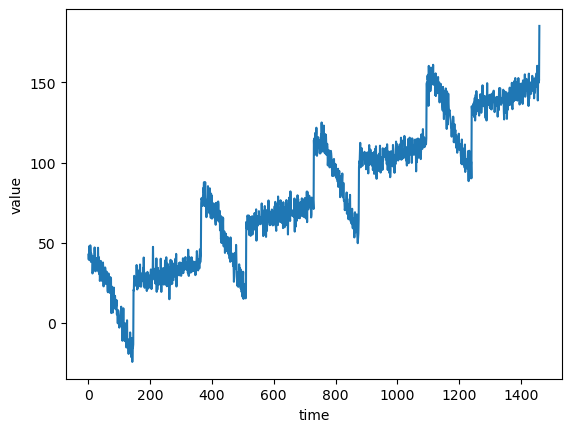

In [48]:
plt.plot(time, series)
plt.xlabel('time')
plt.ylabel('value')

In [49]:
split_time=1000
x_train=series[:split_time]
x_val=series[split_time:]
time_train=time[:split_time]
time_val=time[split_time:]

In [50]:
window=20
batch=32
shuffle_buffer=1000

In [51]:
def windowed_data(series,window,batch,shuffle_buffer):
    data=tf.data.Dataset.from_tensor_slices(series)
    data=data.window(window+1,shift=1,drop_remainder=True)
    data=data.flat_map(lambda i: i.batch(window+1))
    data=data.map(lambda i: (i[:-1], i[-1]))
    data=data.shuffle(shuffle_buffer)
    data=data.batch(batch).prefetch(1)
    return data

In [52]:
dataset=windowed_data(series,window,batch,shuffle_buffer)

In [53]:
for windows in dataset.take(1):
  print(f'data type: {type(windows)}')
  print(f'number of elements in the tuple: {len(windows)}')
  print(f'shape of first element: {windows[0].shape}')
  print(f'shape of second element: {windows[1].shape}')

data type: <class 'tuple'>
number of elements in the tuple: 2
shape of first element: (32, 20)
shape of second element: (32,)


In [ ]:
for x,y in dataset:
  print("x = ", x.numpy())
  print("y = ", y.numpy())
  print()

#### model

In [25]:
layer_0=tf.keras.layers.Dense(1,input_shape=[window])
model=tf.keras.models.Sequential([layer_0])
layer_0.get_weights()

[array([[ 3.4510815e-01],
        [-3.2284170e-01],
        [-3.3231509e-01],
        [-5.1163793e-01],
        [ 4.7468108e-01],
        [-2.5475568e-01],
        [ 2.4074316e-04],
        [-4.2704153e-01],
        [-3.9990610e-01],
        [ 3.1683773e-01],
        [-3.5124606e-01],
        [ 3.2318169e-01],
        [ 1.9009310e-01],
        [-2.1718851e-01],
        [-1.2817591e-01],
        [-8.8761121e-02],
        [ 2.5347710e-02],
        [-3.5544646e-01],
        [ 1.1510253e-02],
        [-1.4971113e-01]], dtype=float32),
 array([0.], dtype=float32)]

20 values for x intercepts and the other array witn the b0 value

In [26]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_1 (Dense)             (None, 1)                 21        
                                                                 
Total params: 21
Trainable params: 21
Non-trainable params: 0
_________________________________________________________________


In [27]:
model.compile(optimizer=tf.keras.optimizers.SGD(learning_rate=1e-6,momentum=0.9),loss='mean_squared_error')

In [ ]:
model.fit(dataset,epochs=100)

In [29]:
layer_0.get_weights()

[array([[ 0.02146673],
        [-0.05597211],
        [ 0.01956754],
        [-0.05296348],
        [ 0.08927373],
        [-0.03445737],
        [-0.00726657],
        [-0.00987929],
        [-0.01242159],
        [ 0.02003863],
        [-0.01967582],
        [ 0.02628027],
        [-0.01707284],
        [ 0.01935119],
        [ 0.00983444],
        [ 0.03871531],
        [ 0.0533237 ],
        [ 0.17719832],
        [ 0.27185568],
        [ 0.41602978]], dtype=float32),
 array([0.01129767], dtype=float32)]

#### prediction

In [35]:
series[0:20]

array([42.48357077, 39.40275206, 43.41473872, 47.86182193, 39.13444534,
       39.18124221, 48.28289687, 44.24712254, 38.07392616, 43.13370684,
       38.09171581, 38.05637547, 41.55941456, 30.73618007, 31.61941291,
       37.3624749 , 35.0282075 , 41.5706442 , 35.35498265, 32.71799162])

In [33]:
series[0:20].shape

(20,)

In [34]:
series[0:20][np.newaxis].shape

(1, 20)

In [31]:
model.predict(series[0:20][np.newaxis])

array([[33.12998]], dtype=float32)

In [38]:
forecast = []
for time in range(len(series)-window):
  forecast.append(model.predict(series[time:time+window][np.newaxis]))

forecast=forecast[split_time-window:]
print(f'length of the forecast list: {len(forecast)}')
print(f'shape of the validation set: {x_val.shape}')

length of the forecast list: 461
shape of the validation set: (461,)


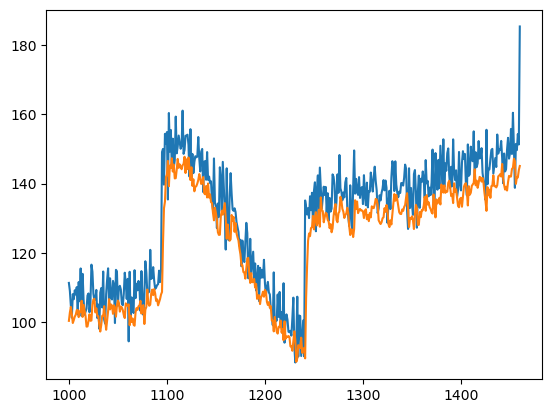

In [41]:
results=np.array(forecast).squeeze()
plt.plot(time_val, x_val)
plt.plot(time_val, results)

In [43]:
print(tf.keras.metrics.mean_squared_error(x_val, results).numpy())
print(tf.keras.metrics.mean_absolute_error(x_val, results).numpy())

82.628204
7.099476


---

## DNN

In [56]:
import tensorflow as tf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

#### data

In [58]:
slope=0.05
period=365
amplitude=40
noise_level=5
baseline=10
time=np.arange(365*4+1)

trend=trend_f(time,slope)
season_time=season_f(time,period)
seasonality=seasonality_f(season_time,amplitude)
noise = noise_f(time,noise_level)

series=baseline+noise+trend+seasonality

Text(0, 0.5, 'value')

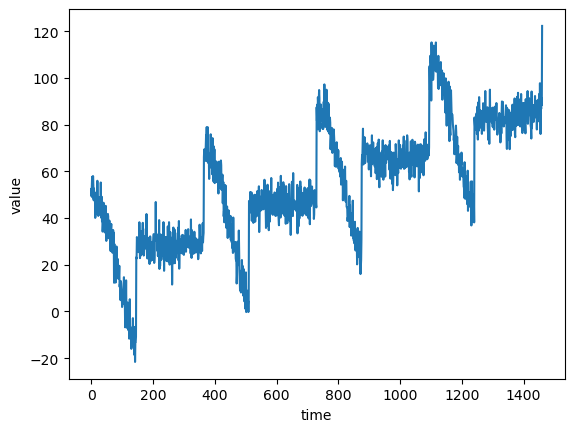

In [59]:
plt.plot(time, series)
plt.xlabel('time')
plt.ylabel('value')

In [60]:
split_time=1000
x_train=series[:split_time]
x_val=series[split_time:]
time_train=time[:split_time]
time_val=time[split_time:]

In [61]:
window=20
batch=32
shuffle_buffer=1000
dataset=windowed_data(series,window,batch,shuffle_buffer)

#### model

In [73]:
model=tf.keras.models.Sequential([
    tf.keras.layers.Dense(10,activation='relu',input_shape=([window])),
    tf.keras.layers.Dense(10,activation='relu'),
    tf.keras.layers.Dense(1)
])
model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_5 (Dense)             (None, 10)                210       
                                                                 
 dense_6 (Dense)             (None, 10)                110       
                                                                 
 dense_7 (Dense)             (None, 1)                 11        
                                                                 
Total params: 331
Trainable params: 331
Non-trainable params: 0
_________________________________________________________________


In [74]:
model.compile(optimizer=tf.keras.optimizers.SGD(learning_rate=1e-6,momentum=0.9),loss='mean_squared_error',metrics=['accuracy'])

In [ ]:
model.fit(dataset,epochs=100)

In [76]:
forecast = []
series_f=series[split_time-window:]
for time in range(len(series_f)-window):
  forecast.append(model.predict(series_f[time:time+window][np.newaxis]))

print(f'length of the forecast list: {len(forecast)}')
print(f'shape of the validation set: {x_val.shape}')

length of the forecast list: 461
shape of the validation set: (461,)


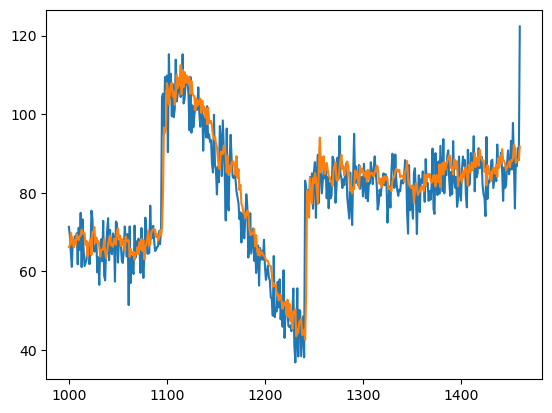

In [77]:
results=np.array(forecast).squeeze()
plt.plot(time_val, x_val)
plt.plot(time_val, results)

In [78]:
print(tf.keras.metrics.mean_squared_error(x_val, results).numpy())
print(tf.keras.metrics.mean_absolute_error(x_val, results).numpy())

44.428543
4.9877076


#### learning rate scheduler

In [ ]:
model=tf.keras.models.Sequential([
    tf.keras.layers.Dense(10,activation='relu',input_shape=([window])),
    tf.keras.layers.Dense(10,activation='relu'),
    tf.keras.layers.Dense(1)
])
lr_schedule=tf.keras.callbacks.LearningRateScheduler(lambda epoch: 1e-8 * 10**(epoch/20))
model.compile(optimizer=tf.keras.optimizers.SGD(momentum=0.9),loss='mean_squared_error',metrics=['accuracy'])
history=model.fit(dataset,epochs=100,callbacks=[lr_schedule])

(1e-08, 0.001, 0.0, 300.0)

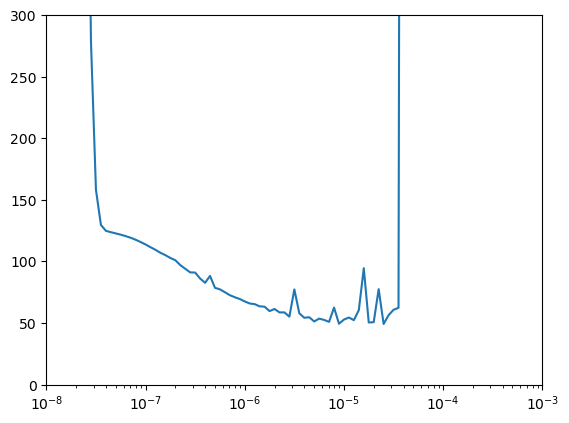

In [83]:
lrs = 1e-8 * (10 ** (np.arange(100) / 20))
plt.semilogx(lrs, history.history["loss"])
plt.axis([1e-8, 1e-3, 0, 300])

In [ ]:
model=tf.keras.models.Sequential([
    tf.keras.layers.Dense(10,activation='relu',input_shape=([window])),
    tf.keras.layers.Dense(10,activation='relu'),
    tf.keras.layers.Dense(1)
])
model.compile(optimizer=tf.keras.optimizers.SGD(learning_rate=4e-6,momentum=0.9),loss='mean_squared_error',metrics=['accuracy'])
history=model.fit(dataset,epochs=100)

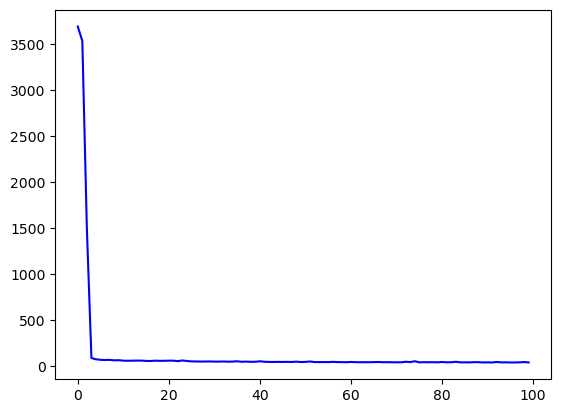

In [87]:
loss = history.history['loss']
epochs = range(len(loss))
plt.plot(epochs, loss, 'b', label='Training Loss')

#### prediction

In [88]:
forecast = []
series_f=series[split_time-window:]
for time in range(len(series_f)-window):
  forecast.append(model.predict(series_f[time:time+window][np.newaxis]))

print(f'length of the forecast list: {len(forecast)}')
print(f'shape of the validation set: {x_val.shape}')

length of the forecast list: 461
shape of the validation set: (461,)


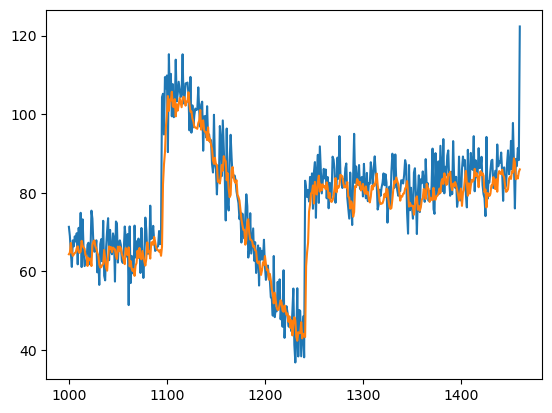

In [89]:
results=np.array(forecast).squeeze()
plt.plot(time_val, x_val)
plt.plot(time_val, results)

In [90]:
print(tf.keras.metrics.mean_squared_error(x_val, results).numpy())
print(tf.keras.metrics.mean_absolute_error(x_val, results).numpy())

47.37988
5.015716
